## Exploration and pre-treatment

In [7]:
import behav_exp_analysis
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering  
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import ward, average, complete, single, fcluster
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Get data from the script of Golan et al 
# df = behav_exp_analysis.data_preprocessing()
# df.to_csv('our_raw_data.csv', index = False)

df = pd.read_csv('our_raw_data.csv')
df.head(2)

,Unnamed: 0,sentence_pair,Trial Number,rating,Response,Reaction Time,counterbalance-o1ql,sentence1_model,sentence2_model,sentence1_type,...,sentence1_model_targeted_to_accept,sentence1_model_targeted_to_reject,subject,subject_group,binarized_choice_probability_NC_LB,binarized_choice_probability_NC_UB,majority_vote_NC_LB,majority_vote_NC_UB,mean_rating_NC_LB,mean_rating_NC_UB
0,0,A message has been sent to your account_They a...,66,2.0,Confident,3525.1,set 1_10,all,all,R,...,NaN,NaN,0,1,0.0,0.0,0.0,0.0,1.333333,1.4
1,1,A road closure is unlikely to impact service_I...,12,3.0,Somewhat confident,7541.2,set 1_10,xlm,trigram,N,...,NaN,NaN,0,1,0.0,0.0,0.0,0.0,1.666667,1.8


In [2]:
## Enrich dataframe  ##

# Selected sentence
df.loc[(df['rating'] <= 3), 'subject_selected_sentence'] = 1
df.loc[(df['rating'] > 3) , 'subject_selected_sentence'] = 2

# Majority vote for each item
mode_per_group = df.groupby('sentence_pair')['subject_selected_sentence'].transform(lambda x: x.mode().iloc[0])
df['subjects_majority_vote'] = mode_per_group

# If the subject picked the most popular response for that item
df['subject_chose_majority'] = 0
df.loc[df['subject_selected_sentence'].eq(df['subjects_majority_vote']), 'subject_chose_majority'] = 1

# Participants level of agreement per item
agreement = []
key = []
trial_type = []

for pair in df.sentence_pair.unique():
    subset = df[df.sentence_pair == pair]
    perc_maj = (lambda x: 1 - x)(len(subset[subset.subject_selected_sentence==1])/len(subset)) if len(subset[subset.subject_selected_sentence==1])/len(subset) < 0.5 else (len(subset[subset.subject_selected_sentence==1])/len(subset))
    agreement.append(perc_maj)
    key.append(pair)
    trial_type.append(subset.trial_type.unique()[0])

df_agreement = pd.DataFrame({'sentence_pair':key,'trial_type':trial_type, 'agreement':agreement})

df = pd.merge(df, df_agreement[['sentence_pair', 'agreement']], on='sentence_pair', how='inner')


In [3]:
# Visualize participants agreement per condition
agreement = {}
for trial_type in df.trial_type.unique():
    for pair in df.sentence_pair.unique():
        subset = df[(df.trial_type == trial_type) & (df.sentence_pair == pair)]
        if len(subset) > 0:
            perc_maj = (lambda x: 1 - x)(len(subset[subset.subject_selected_sentence==1])/len(subset)) if len(subset[subset.subject_selected_sentence==1])/len(subset) < 0.5 else (len(subset[subset.subject_selected_sentence==1])/len(subset))
            if trial_type in agreement:
                agreement[trial_type].append(perc_maj)
            else:
                agreement[trial_type] = [perc_maj]


for key in agreement :
    print(key)
    print(f'{len(agreement[key])} sentence pairs')
    print(f'average proportion of votes for the majority : {round(np.mean(agreement[key]),3)}')
    print(f'standard deviation of proportion of votes for the majority : {round(np.std(agreement[key]),3)} \n')


randomly_sampled_natural
90 sentence pairs
average proportion of votes for the majority : 0.81
standard deviation of proportion of votes for the majority : 0.168 

natural_vs_synthetic
720 sentence pairs
average proportion of votes for the majority : 0.879
standard deviation of proportion of votes for the majority : 0.147 

synthetic_vs_synthetic
360 sentence pairs
average proportion of votes for the majority : 0.852
standard deviation of proportion of votes for the majority : 0.154 

natural_controversial
360 sentence pairs
average proportion of votes for the majority : 0.77
standard deviation of proportion of votes for the majority : 0.16 

natural_vs_shuffled
120 sentence pairs
average proportion of votes for the majority : 0.991
standard deviation of proportion of votes for the majority : 0.037 



In [4]:
# Replicate the article summary of behavioral results (page 961)
agreement = {}

for trial_type in df.trial_type.unique():
    for pair in df.sentence_pair.unique():
        subset = df[(df.trial_type == trial_type) & (df.sentence_pair == pair)].copy()
        if len(subset) > 0:
            if len(subset[subset.subject_selected_sentence ==1]) <= 1 or len(subset[subset.subject_selected_sentence==1]) >= 9:
                
                if trial_type in agreement:
                    agreement[trial_type].append(1)
                else:
                    agreement[trial_type] = [1]
            else :
                if trial_type in agreement:
                    agreement[trial_type].append(0)
                else:
                    agreement[trial_type] = [0]



for key in agreement :
    print(key)
    print(f'{len(agreement[key])} sentence pairs')
    print(f'proportion of items with at least 90% of participants in favor of the same option : {round(np.mean(agreement[key]),3)}\n')


randomly_sampled_natural
90 sentence pairs
proportion of items with at least 90% of participants in favor of the same option : 0.522

natural_vs_synthetic
720 sentence pairs
proportion of items with at least 90% of participants in favor of the same option : 0.676

synthetic_vs_synthetic
360 sentence pairs
proportion of items with at least 90% of participants in favor of the same option : 0.6

natural_controversial
360 sentence pairs
proportion of items with at least 90% of participants in favor of the same option : 0.367

natural_vs_shuffled
120 sentence pairs
proportion of items with at least 90% of participants in favor of the same option : 0.992



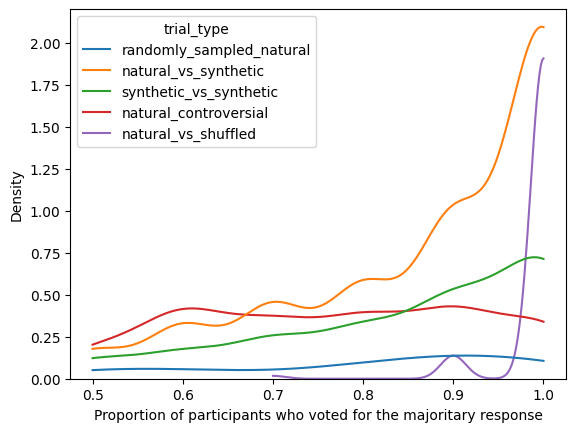

In [5]:
sns.kdeplot(data=df_agreement, x='agreement', hue='trial_type', cut=0)
plt.xlabel('Proportion of participants who voted for the majoritary response');

Within conditions the item difficulty level is very heterogeneous. This prevents us from aggregating results per condition.

In [6]:
## Pre-treatment ##
df['Reaction Time'] = np.log(df['Reaction Time'])

# Dummy coding
label_mapping = {}

for col in ['Response', 'sentence1_type', 'sentence2_type']:
    df[col] = df[col].astype('category')
    if col == 'Response':
        label_mapping[col] = {1: 'Confident', 0: 'Somewhat confident', 2: 'Very confident'}
    else:
        label_mapping[col] = dict(enumerate(df[col].cat.categories))
    df[col] = df[col].cat.codes
    

# Aggregate each particpant's responses by item difficulty
sub_df = df.groupby(['subject','agreement'])['Reaction Time', 'Response', 'subject_chose_majority'].mean().reset_index() 
    
# Pivot the DataFrame to have one row per subject with columns per item difficulty
sub_df = sub_df.pivot(index='subject', columns='agreement')
sub_df.columns = ['_'.join(map(str, col)) for col in sub_df.columns.values]
sub_df = sub_df.reset_index()

# Standardize the features
selected_columns = [col for col in sub_df.columns if col != 'subject']

scaler = StandardScaler()
sub_df[selected_columns] = scaler.fit_transform(sub_df[selected_columns])

/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  app.launch_new_instance()


# Hierarchical clustering

Explained variation per principal component: [0.33631331 0.27117772 0.11470719 0.06114371 0.04968602 0.03984934
 0.02493381 0.02150578 0.01905307 0.01447206]


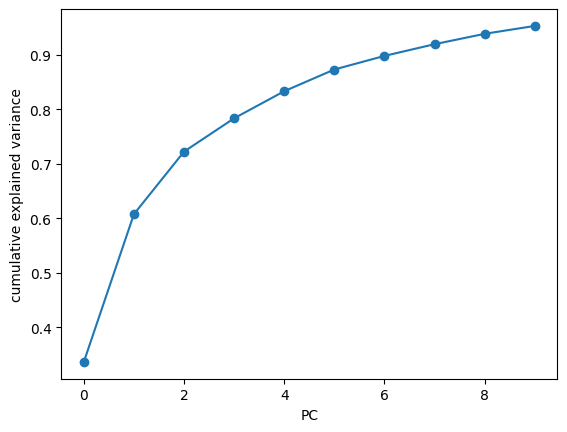

In [7]:
# Dimension reduction
pca_model = PCA(n_components=10)
principal_components = pca_model.fit_transform(sub_df[selected_columns])

# PCA evaluation
print('Explained variation per principal component: {}'.format(pca_model.explained_variance_ratio_))
plt.plot(np.cumsum(pca_model.explained_variance_ratio_),'o-')
plt.xlabel('PC')
plt.ylabel('cumulative explained variance');

In [8]:
# Select 3 principal components
pca_df = pd.DataFrame(data = principal_components[:,:3], columns = ['PC1', 'PC2', 'PC3'])

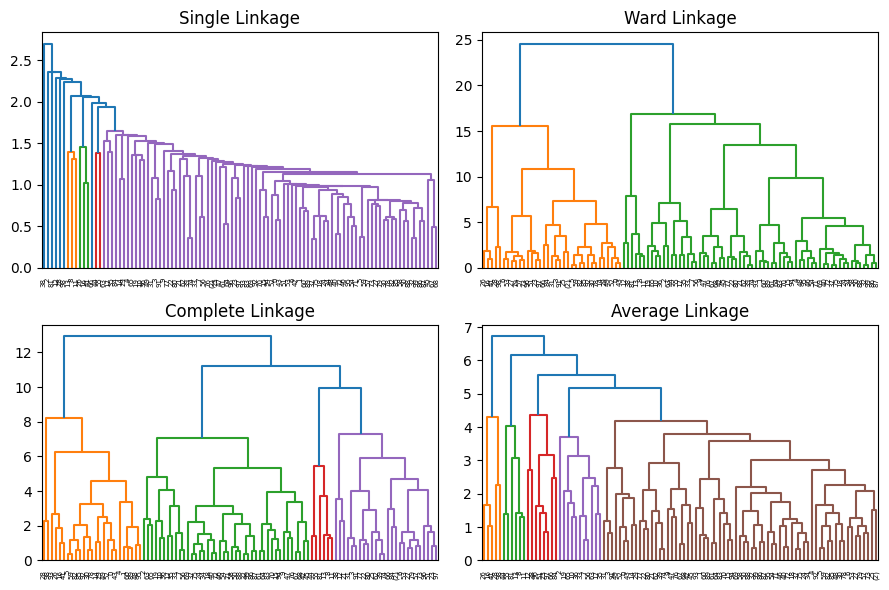

In [9]:
# Plot the dendrogram to select the linkage and gauge the number of clusters
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
dendrogram1 = sch.dendrogram(sch.linkage(pca_df, method='single'), 
                             truncate_mode='lastp', p=99, ax=axes[0, 0])
axes[0, 0].set_title('Single Linkage')

dendrogram2 = sch.dendrogram(sch.linkage(pca_df, method='ward'), 
                             truncate_mode='lastp', p=99, ax=axes[0, 1])
axes[0, 1].set_title('Ward Linkage')

dendrogram3 = sch.dendrogram(sch.linkage(pca_df, method='complete'), 
                             truncate_mode='lastp', p=99, ax=axes[1, 0])
axes[1, 0].set_title('Complete Linkage')

dendrogram4 = sch.dendrogram(sch.linkage(pca_df, method='average'), 
                             truncate_mode='lastp', p=99, ax=axes[1, 1])
axes[1, 1].set_title('Average Linkage')


plt.tight_layout()
plt.show()


In [10]:
# Perform hierarchical clustering
model = AgglomerativeClustering(n_clusters=5, distance_threshold=None, linkage='average') 
sub_df['cluster'] = model.fit_predict(sub_df[selected_columns])
sub_df['cluster'] = sub_df['cluster'].astype('str')


df = pd.merge(df, sub_df[['subject', 'cluster']], on='subject', how='inner')

In [11]:
# Same as below with all in one figure for report
# ## Assess clustering results ## 

# sub_df_cond = df.groupby(['subject','agreement', 'cluster']).mean().reset_index()

# _, ax = plt.subplots(3, sharex=True,figsize=(10,10))

# ax1 = sns.violinplot(data=sub_df_cond, x='agreement', y='subject_chose_majority', hue='cluster', cut=0, ax=ax[0])
# ax2 = sns.violinplot(data=sub_df_cond, x='agreement', y='Response', hue='cluster', cut=0, ax=ax[1], legend=False)
# ax3 = sns.violinplot(data=sub_df_cond, x='agreement', y='Reaction Time', hue='cluster', cut=0, ax=ax[2], legend=False)
# ax2.get_legend().remove()
# ax3.get_legend().remove()
# ax1.set_xlabel('')
# ax1.set_ylabel('Agreement with majority')
# ax2.set_xlabel('')
# ax3.set_xlabel('Item difficulty (inverse)')
# ax1.set_title('Visualization of participants clusters')
# sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))


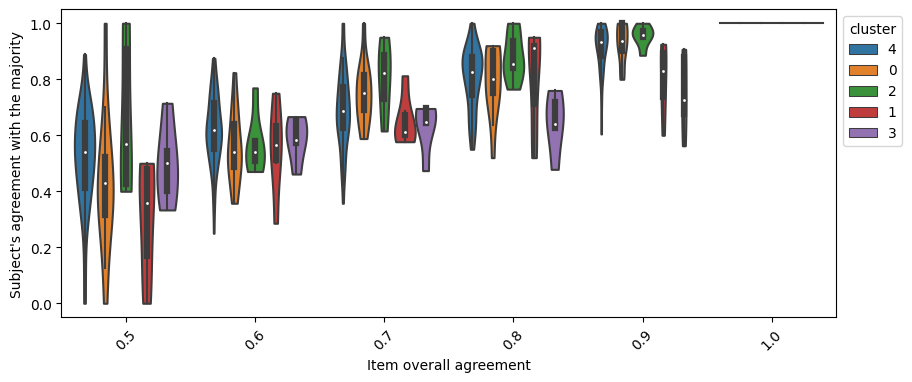

In [12]:
## Assess clustering results ##

sub_df_cond = df.groupby(['subject','agreement', 'cluster']).mean().reset_index()


plt.figure(figsize=(10,4))
ax = sns.violinplot(data=sub_df_cond, x='agreement', y='subject_chose_majority', hue='cluster', cut=0)
plt.tick_params(axis='x', rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylabel('Subject\'s agreement with the majority')
plt.xlabel('Item overall agreement');

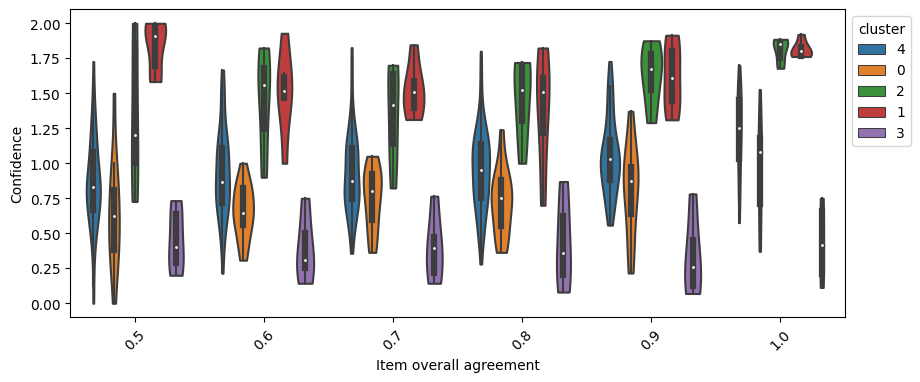

In [13]:
plt.figure(figsize=(10,4))
ax = sns.violinplot(data=sub_df_cond, x='agreement', y='Response', hue='cluster', cut=0)
plt.tick_params(axis='x', rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Item overall agreement')
plt.ylabel('Confidence');

In [14]:
# Test interaction between cluster and item difficulty on confidence
model = smf.mixedlm("Response ~ 0 + cluster + agreement:cluster", sub_df_cond, groups=sub_df_cond["subject"])
result = model.fit()

# Print the summary of the mixed model
print(result.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Response
No. Observations:    600        Method:                REML    
No. Groups:          100        Scale:                 0.0456  
Min. group size:     6          Log-Likelihood:        -28.5327
Max. group size:     6          Converged:             Yes     
Mean group size:     6.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
cluster[0]            0.313    0.115  2.732 0.006  0.089  0.538
cluster[1]            1.602    0.181  8.837 0.000  1.247  1.958
cluster[2]            0.882    0.181  4.866 0.000  0.527  1.237
cluster[3]            0.455    0.199  2.292 0.022  0.066  0.845
cluster[4]            0.515    0.054  9.559 0.000  0.409  0.620
agreement:cluster[0]  0.589    0.132  4.470 0.000  0.

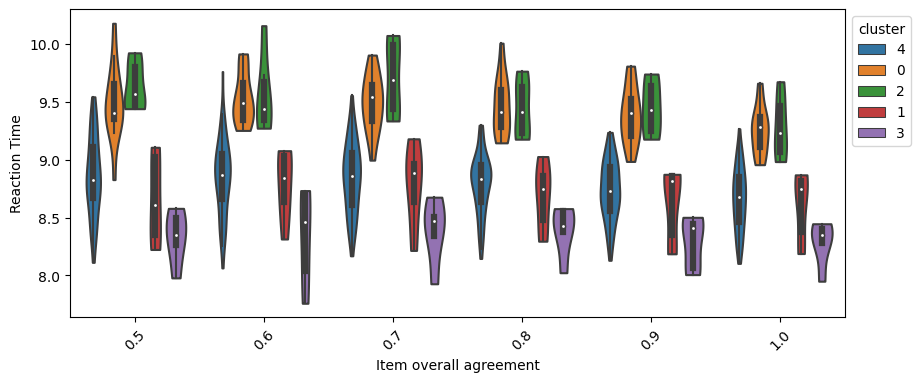

In [15]:
plt.figure(figsize=(10,4))
ax = sns.violinplot(data=sub_df_cond, x='agreement', y='Reaction Time', hue='cluster', cut=0)
plt.tick_params(axis='x', rotation=45)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Item overall agreement');

In [16]:
# Test interaction between cluster and item difficulty on response time
sub_df_cond['RT'] = sub_df_cond['Reaction Time']
model = smf.mixedlm("RT ~ 0 + cluster + agreement:cluster", sub_df_cond, groups=sub_df_cond["subject"])
result = model.fit()

# Print the summary of the mixed model
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    RT      
No. Observations:     600        Method:                REML    
No. Groups:           100        Scale:                 0.0235  
Min. group size:      6          Log-Likelihood:        124.9428
Max. group size:      6          Converged:             Yes     
Mean group size:      6.0                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
cluster[0]            9.796    0.096 101.769 0.000  9.608  9.985
cluster[1]            8.877    0.152  58.324 0.000  8.579  9.175
cluster[2]           10.023    0.152  65.856 0.000  9.725 10.322
cluster[3]            8.420    0.167  50.503 0.000  8.094  8.747
cluster[4]            9.089    0.045 201.042 0.000  9.001  9.178
agreement:cluster[0] -0.478    0.095  -

In [17]:
# Label the clusters
df.loc[df['cluster'] == '4', 'cluster'] = 'average'
df.loc[df['cluster'] == '1', 'cluster'] = 'overconfident'
df.loc[df['cluster'] == '2', 'cluster'] = 'engaged_accurate'
df.loc[df['cluster'] == '3', 'cluster'] = 'disengaged'
df.loc[df['cluster'] == '0', 'cluster'] = 'engaged_struggling'

In [18]:
# IDs of engaged participants
df[df['cluster'].isin(['engaged_accurate', 'engaged_struggling'])].subject.unique()

array([ 2,  7,  8,  9, 10, 11, 13, 17, 19, 35, 36, 44, 33, 81, 55, 56, 70,
       83, 63, 65, 72])

## Clustering results

We used subjects' level of consensus to measure item difficulty. We found that item difficulty was highly variable within conditions. This suggested that two items in the same condition might require different cognitive processes or effort to solve. Therefore, it would have been incorrect to aggregate participants' responses by condition, and item difficulty was a better candidate for aggregation.

Consequently, we represented each participant by their reaction time, confidence level, and agreement with the majority, per item difficulty. To optimise the clustering results, we first performed a principal component analysis. Then, 5 clusters were extracted using agglomerative hierarchical clustering with average linkage.

The clusters we found are very well separated in terms of reaction time and confidence. We have:
- Disengaged participants: a cluster (3) of fast participants, with low confidence and suboptimal agreement with the majority (accuracy).
- Engaged and performant participants: a cluster (2) of slow participants, with a high level of confidence and a high level of accuracy. 
- Engaged but struggling participants: a cluster (0) of slow participants, with a low level of confidence and a high level of accuracy.
- Overconfident participants: a cluster (1) of fast participants, with a high level of confidence and suboptimal accuracy 
- Average participants : a cluster (4) without salient properties

Contrary to the other groups, the disengaged and overconfident participants didn't adapted their behavior to task difficulty. The other groups slowed down and were less confident as item difficulty increased.


This result supports that people use different strategies to perform this task. The question therefore arises as to what behaviour the LLMs should reproduce. In our case, the most interesting groups are the engaged ones. Nevertheless, selecting only two clusters represents a significant loss of data. This could be addressed by simply excluding the disengaged and overconfident groups but presents the disadvantage of including an ill characterized group (i.e average).

## Clusters and GPT data enrichment

In [19]:
## Behavioral features when keeping only engaged participants ## 

# Majority vote for each item in engaged and average participants
selected_rows = df[df['cluster'].isin(['engaged_struggling', 'engaged_accurate'])]

mode_per_group = selected_rows.groupby('sentence_pair')['subject_selected_sentence'].transform(lambda x: x.mode().iloc[0])
selected_rows['subjects_majority_vote_2clusters'] = mode_per_group

df = pd.merge(df, selected_rows[['sentence_pair', 'subjects_majority_vote_2clusters']], on='sentence_pair', how='inner')


# If the subject picked the most popular response for that item
df['subject_chose_majority_2clusters'] = 0
df.loc[df['subject_selected_sentence'].eq(df['subjects_majority_vote_2clusters']), 'subject_chose_majority_2clusters'] = 1

# Participants level of agreement per item for kept clusters
agreement = []
key = []
trial_type = []

for pair in df.sentence_pair.unique():
    subset = df[(df.sentence_pair == pair) & (df['cluster'].isin(['engaged_struggling', 'engaged_accurate']))]
    perc_maj = (lambda x: 1 - x)(len(subset[subset.subject_selected_sentence==1])/len(subset)) if len(subset[subset.subject_selected_sentence==1])/len(subset) < 0.5 else (len(subset[subset.subject_selected_sentence==1])/len(subset))
    agreement.append(perc_maj)
    key.append(pair)
    trial_type.append(subset.trial_type.unique()[0])

df_agreement = pd.DataFrame({'sentence_pair':key,'trial_type':trial_type, 'agreement_2clusters':agreement})

df = pd.merge(df, df_agreement[['sentence_pair', 'agreement_2clusters']], on='sentence_pair', how='inner')


/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [20]:
# Number of items for which the majority vote changes when only including the engaged participants
len(df[df['subjects_majority_vote_2clusters'] != df['subjects_majority_vote']].groupby('sentence_pair'))

181

In [21]:
# Create column to easily select GPT items during further analysis
df['include_as_gpt_item'] = df.apply(lambda row: True if row['trial_type'] in ['natural_vs_shuffled', 'randomly_sampled_natural']
                                     else (True if (row['sentence2_model_targeted_to_accept'] == 'gpt2') else 
                                           (True if (row['sentence1_model_targeted_to_accept'] == 'gpt2') else False)),axis=1)


In [22]:
def get_gpt_choice(row):
    if row['include_as_gpt_item'] is True:
        if row['trial_type'] in ['natural_vs_shuffled', 'randomly_sampled_natural']:
            return 1.0 if row['sentence1_gpt2_prob'] > row['sentence2_gpt2_prob'] else 2.0
        else:
            return 2.0 if row['sentence2_model_targeted_to_accept'] == 'gpt2' else 1.0
    else: 
        return np.nan

# Create column for GPT choice
df['gpt_choice'] = [get_gpt_choice(row) for _, row in df.iterrows()]

# Create column for GPT agreement with all subjects
df.loc[df['include_as_gpt_item'] == True, 'gpt_all_subjects_agreement'] = np.where(
    df.loc[df['include_as_gpt_item'] == True, 'gpt_choice'] == df.loc[df['include_as_gpt_item'] == True, 'subjects_majority_vote'], 
    1, 
    0
)

# Create column for GPT agreement with engaged subjects
df.loc[df['include_as_gpt_item'] == True, 'gpt_engaged_subjects_agreement'] = np.where(
    df.loc[df['include_as_gpt_item'] == True, 'gpt_choice'] == df.loc[df['include_as_gpt_item'] == True, 'subjects_majority_vote_2clusters'], 
    1, 
    0
)

In [23]:
# Save enriched data to csv
df.to_csv('our_df.csv', index = False)

## Reproduce paper figures with engaged subjects

In [24]:
# Execute code from Golan and coll.(2023) 
! python our_behav_exp_analysis_2clusters.py

figure natural_and_natural_controversial_binarized_accuracy.pdf size: 5.612461179749811,4.883333333333333 inches
/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
Randomly sampled natural-sentence pairs
index                                  6267.534392
Unnamed: 0                             6267.534392
Trial Number                             88.497354
rating                                    3.513228
Reaction Time                         15265.013545
sentence2_model_targeted_to_accept             NaN
sentence2_model_targeted_to_reject      

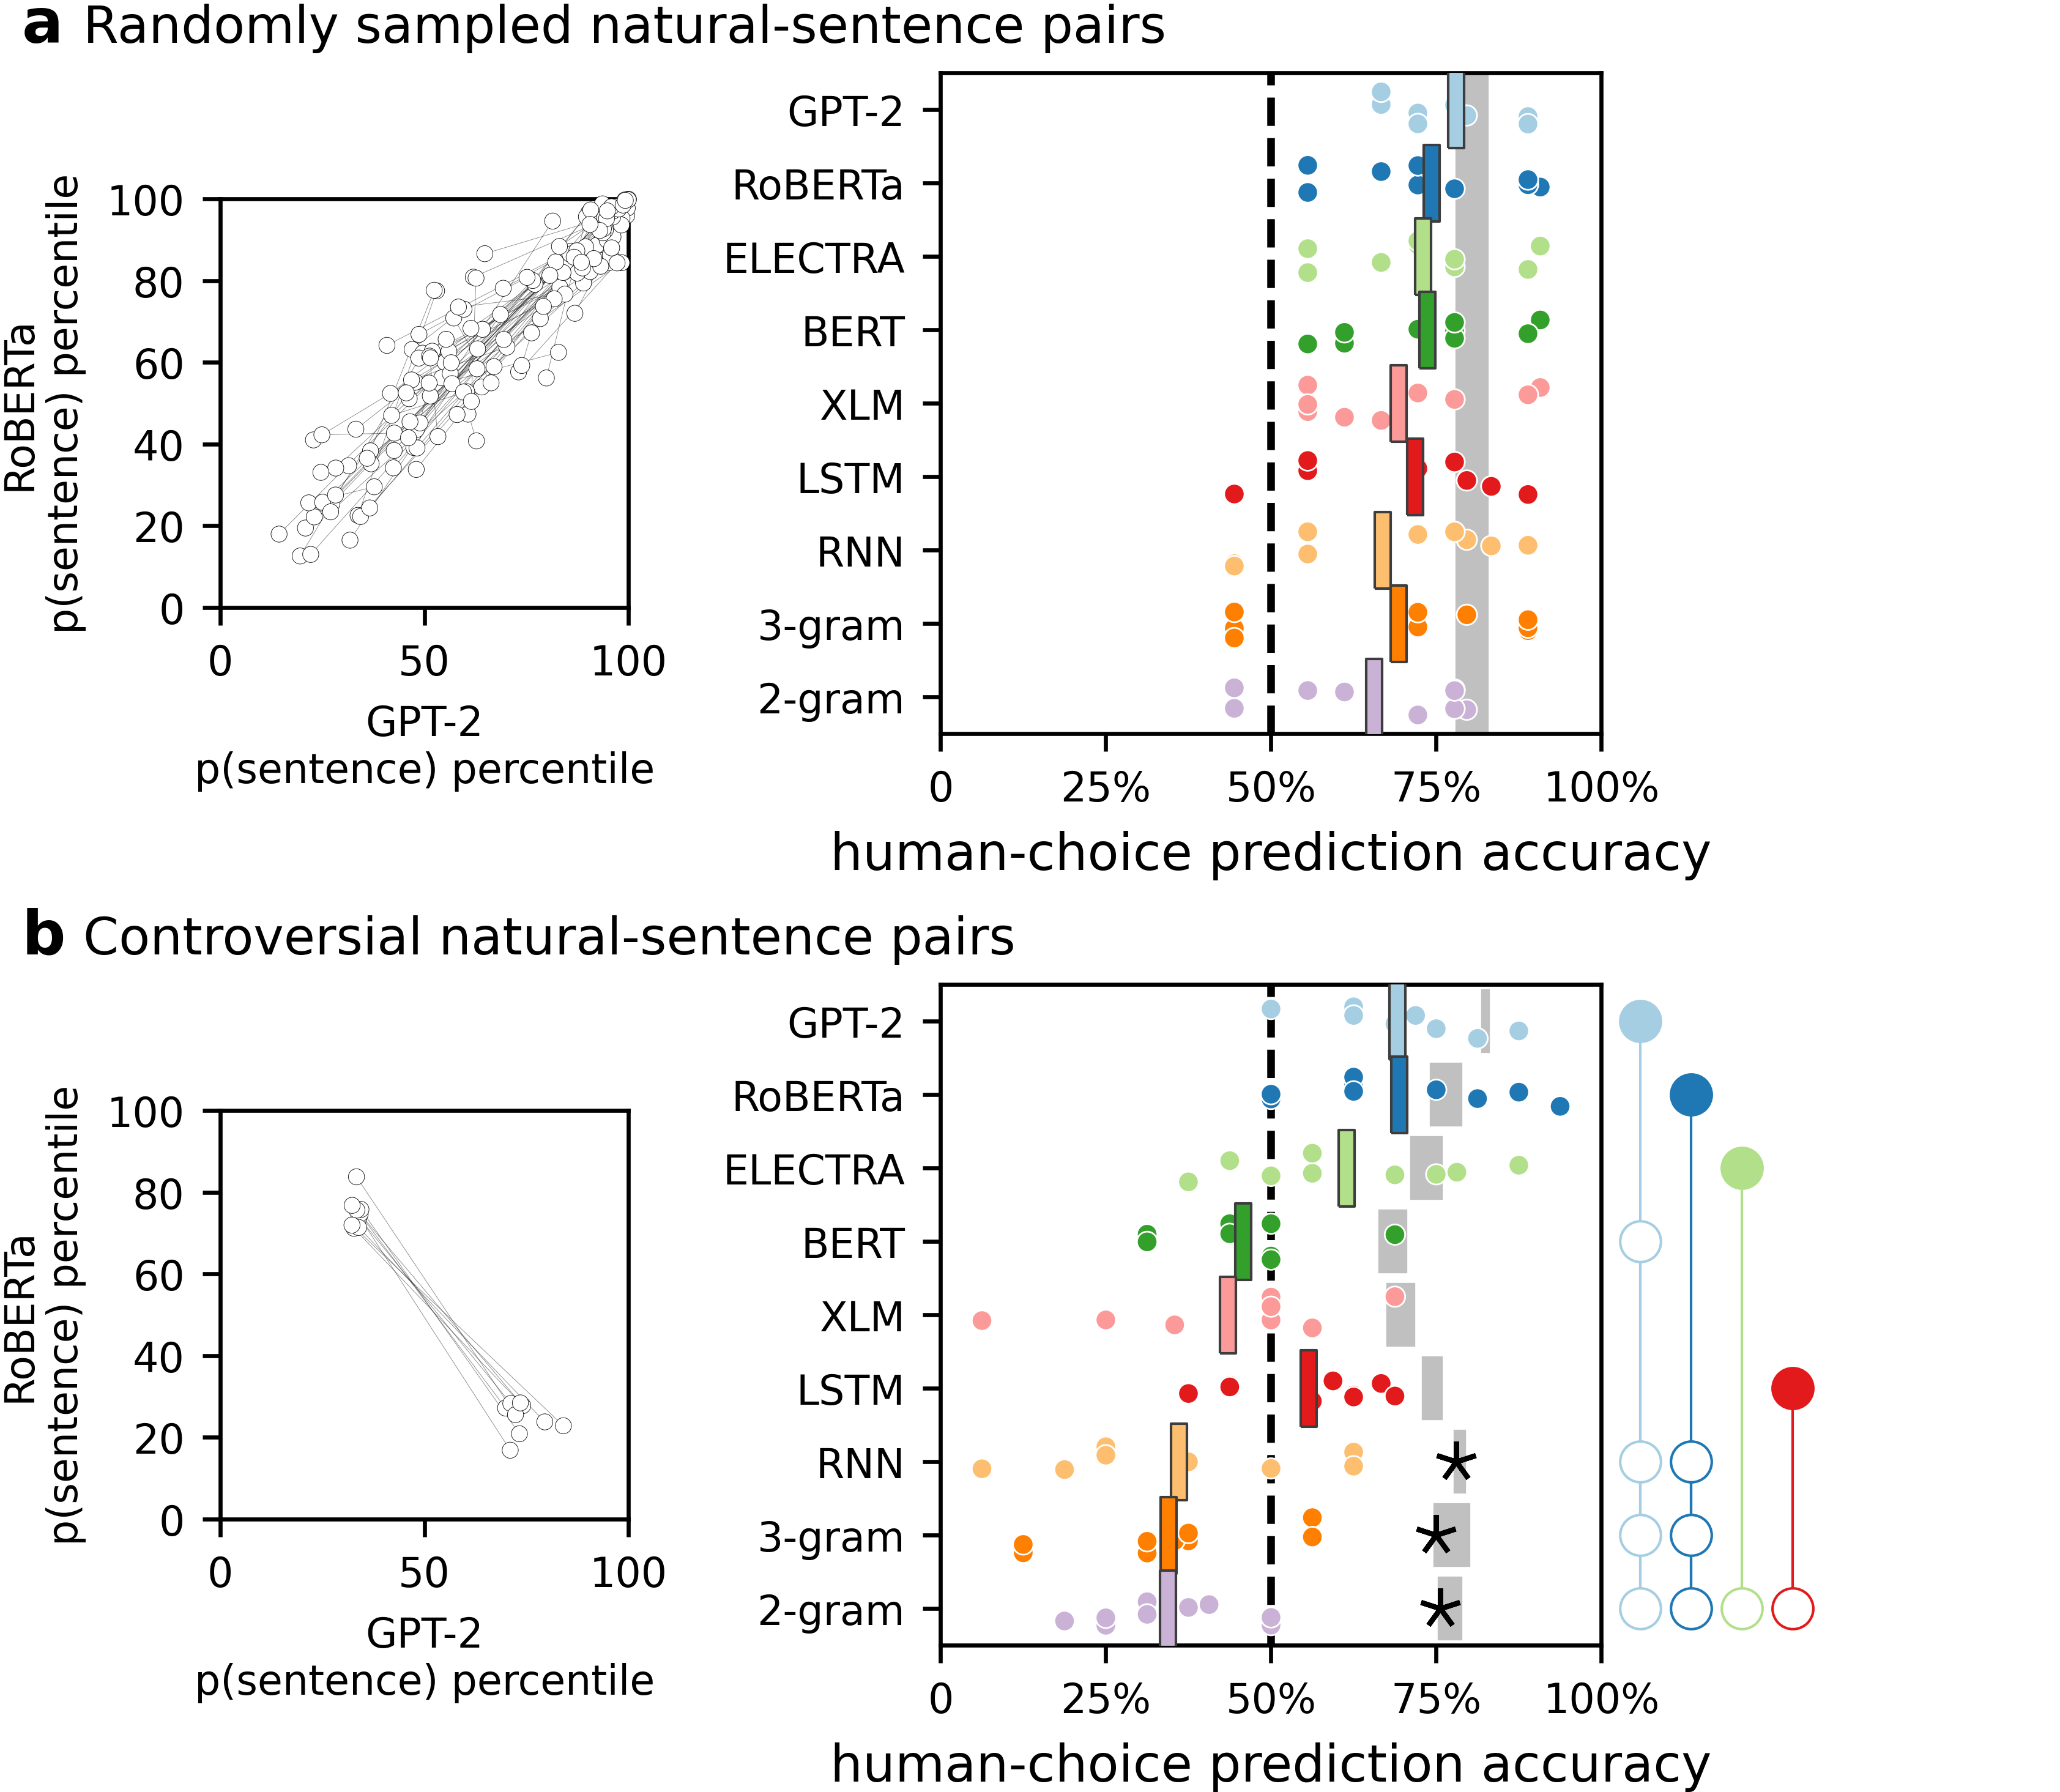

In [25]:
from IPython.display import Image
Image(filename='our_figures_2clusters/binarized_acc/natural_and_natural_controversial_binarized_accuracy.png') 

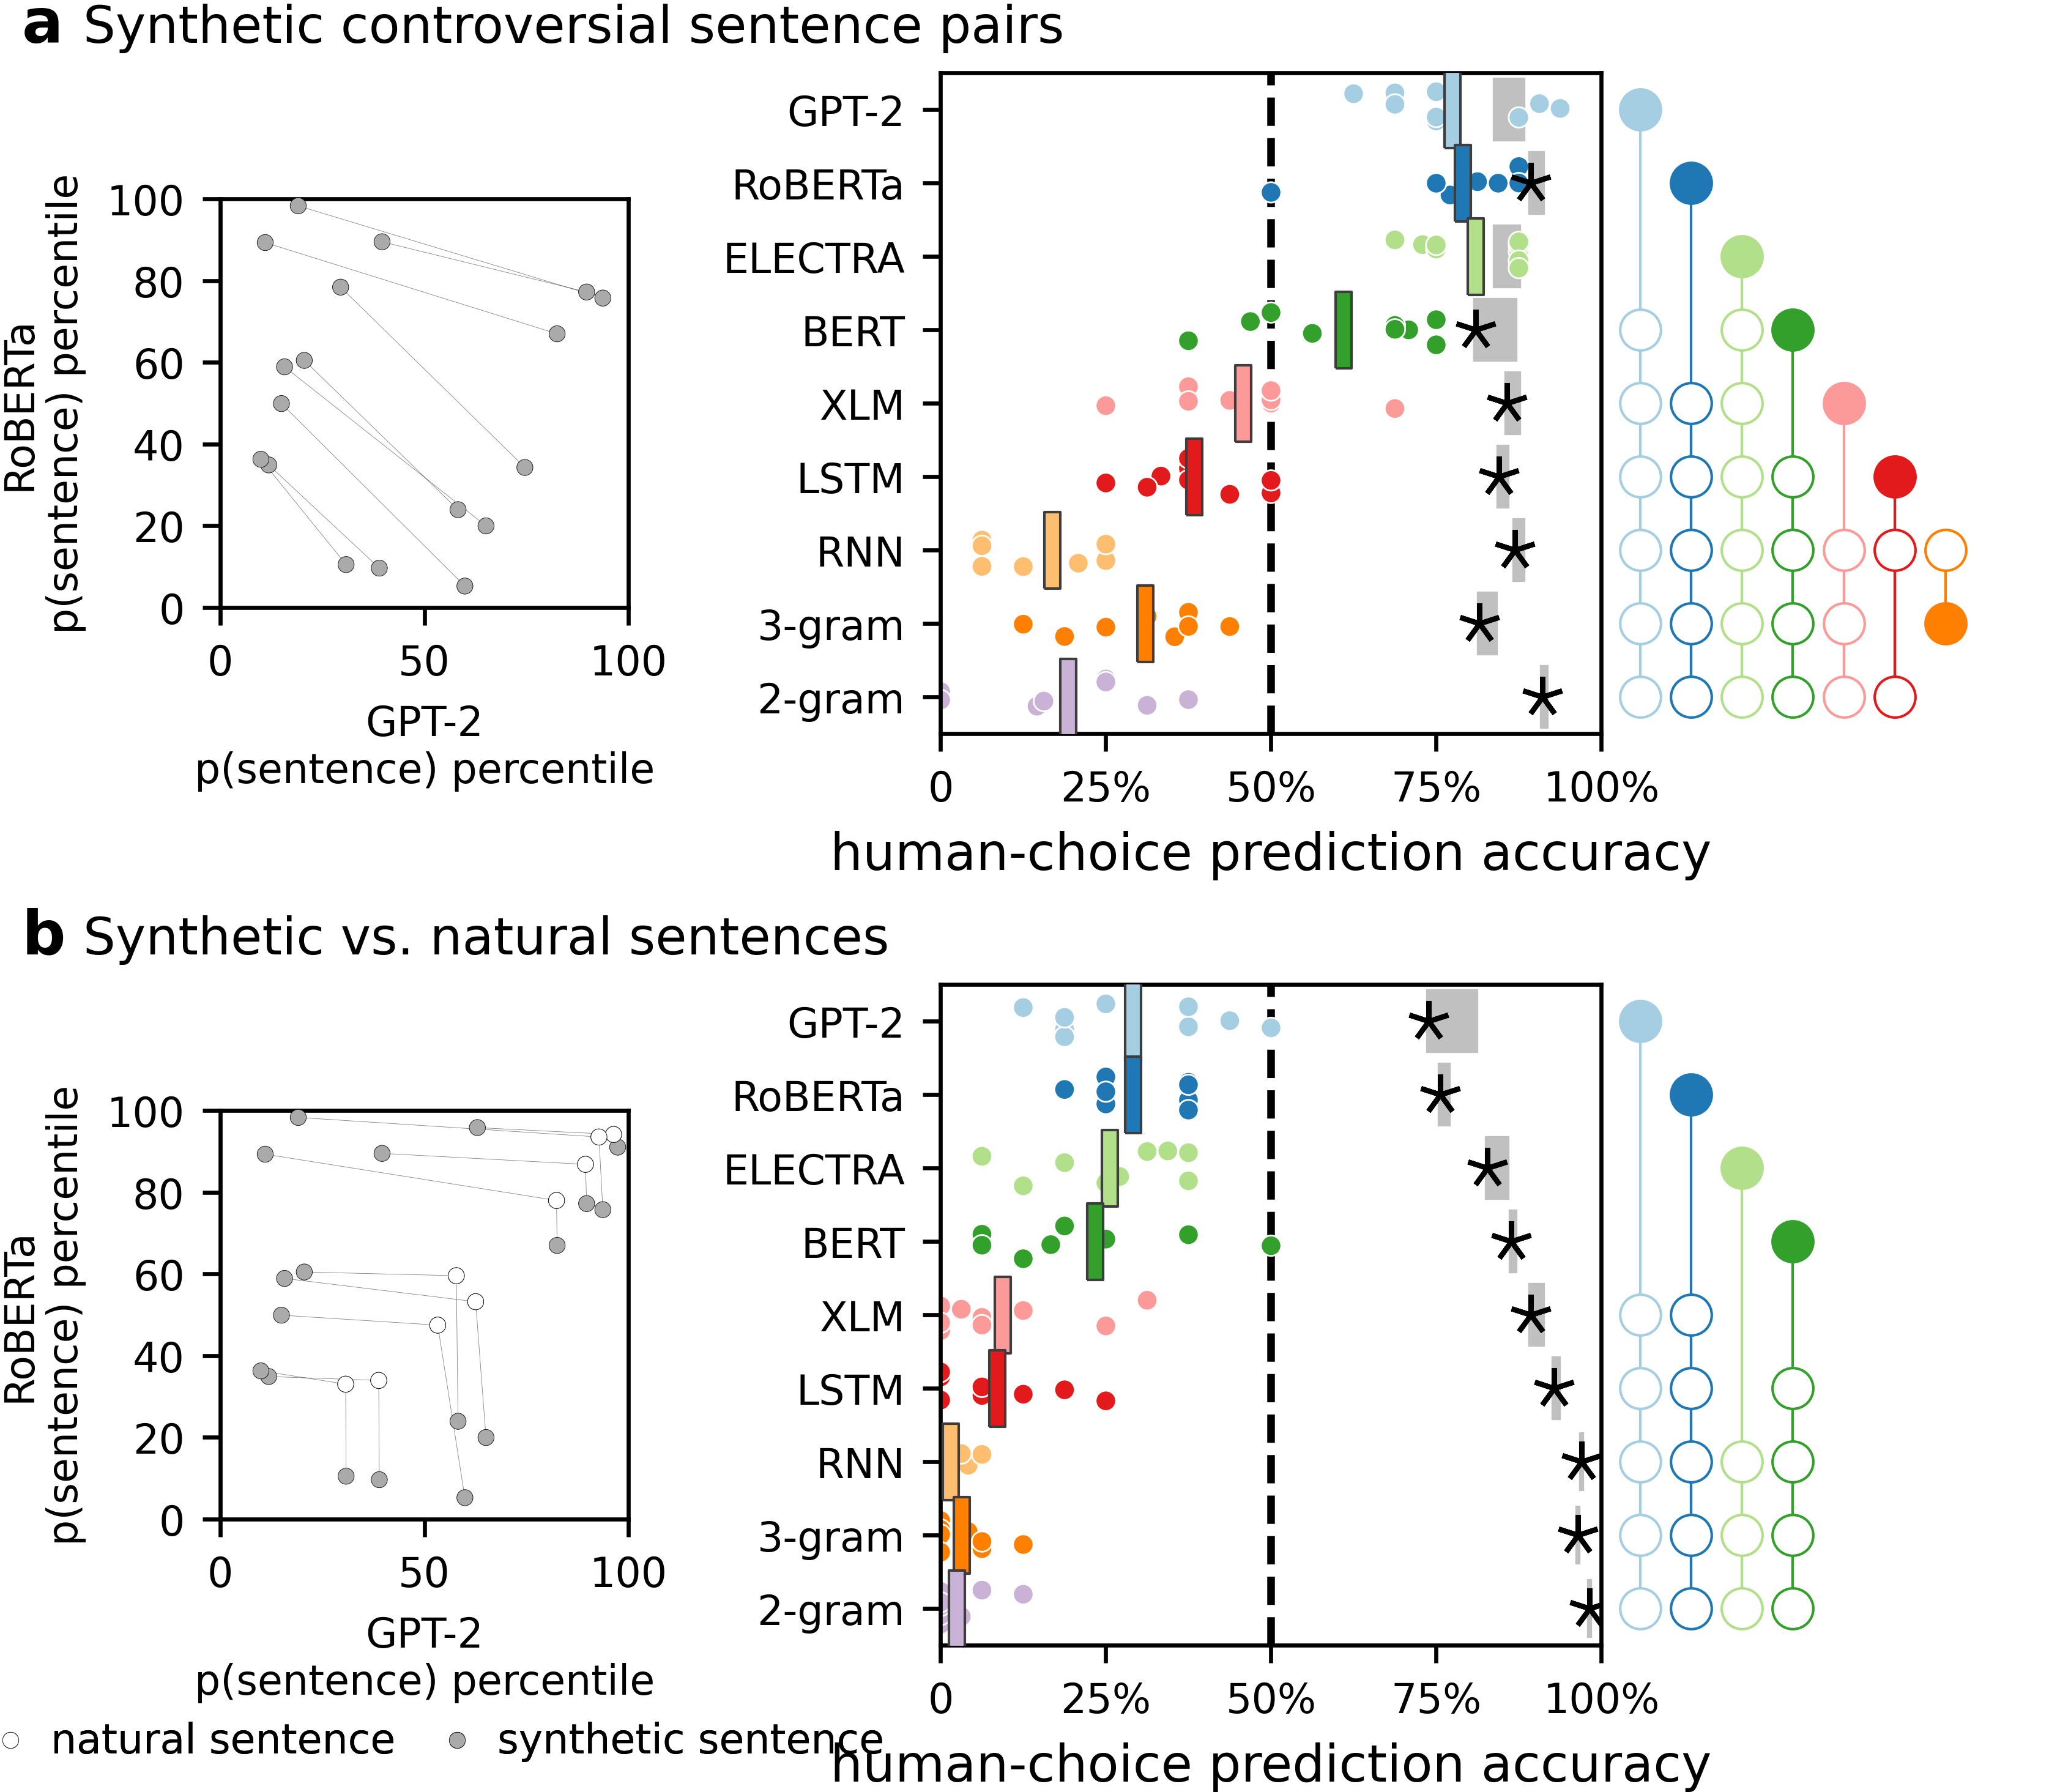

In [26]:
Image(filename='our_figures_2clusters/binarized_acc/synthetic_binarized_accuracy.png') 

# Plot GPT-subjects agreement

[('natural_controversial', 0.7777777777777778), ('natural_vs_shuffled', 1.0), ('natural_vs_synthetic', 0.19444444444444445), ('randomly_sampled_natural', 0.8271604938271605), ('synthetic_vs_synthetic', 0.8194444444444444)]


/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]
/home/lea/anaconda3/envs/contstimlang/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator


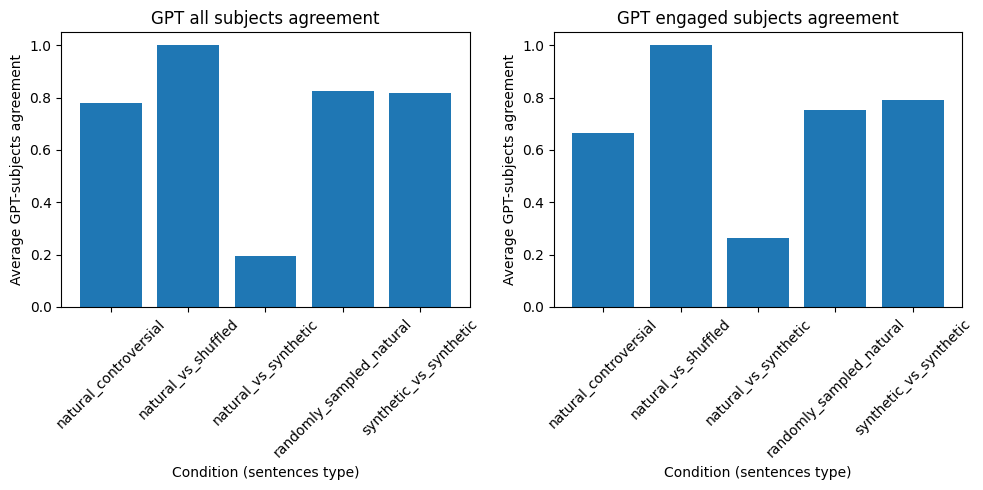

In [31]:

_, ax = plt.subplots(1,2, figsize=(10,5))
items_df = df[df['include_as_gpt_item'] == True].groupby('sentence_pair')[['trial_type', 'gpt_all_subjects_agreement']].first()

# GPT vs all subjects
avg_gpt_subject_agreement = items_df.groupby('trial_type')['gpt_all_subjects_agreement'].mean()

print(list(zip(avg_gpt_subject_agreement.index, avg_gpt_subject_agreement.values)))
# Plot
ax[0].bar(avg_gpt_subject_agreement.index, avg_gpt_subject_agreement.values)
ax[0].set_xlabel('Condition (sentences type)')
ax[0].set_ylabel('Average GPT-subjects agreement')
ax[0].set_title('GPT all subjects agreement')
ax[0].set_xticklabels(avg_gpt_subject_agreement.index,rotation=45)

items_df = df[df['include_as_gpt_item'] == True].groupby('sentence_pair')[['trial_type', 'gpt_engaged_subjects_agreement']].first()

# GPT vs engaged subjects
avg_gpt_subject_agreement = items_df.groupby('trial_type')['gpt_engaged_subjects_agreement'].mean()
#print(list(zip(avg_gpt_subject_agreement.index, avg_gpt_subject_agreement.values)))
# Plot
ax[1].bar(avg_gpt_subject_agreement.index, avg_gpt_subject_agreement.values)
ax[1].set_xlabel('Condition (sentences type)')
ax[1].set_ylabel('Average GPT-subjects agreement')
ax[1].set_title('GPT engaged subjects agreement')
ax[1].set_xticklabels(avg_gpt_subject_agreement.index,rotation=45)
plt.tight_layout()
plt.show()


In [28]:
gpt_natural_vs_synthetic = df[(df['include_as_gpt_item'] == True) & (df['trial_type'] == 'natural_vs_synthetic')][['gpt_engaged_subjects_agreement','sentence1', 'sentence2','gpt_choice','sentence_pair']].groupby('sentence_pair').first()


In [29]:
# Correct GPT responses in natural vs synthetic
gpt_natural_vs_synthetic.loc[gpt_natural_vs_synthetic['gpt_engaged_subjects_agreement'] == 1, ['sentence1', 'sentence2', 'gpt_choice']].style.hide_index()


sentence1,sentence2,gpt_choice
Afterward my arm was ready to fall off,Thought his head was about to fall off,1.000000
All of you get to have your feelings,Both of you get to keep your axes,2.000000
Break away and concentrate on yourself for once,Break up and work on yourself for awhile,1.000000
Gets us in the playoffs next off year,Gets us to the playoffs every following year,1.000000
Hard to play maps that are absolute garbage,How to handle races that are outright incomprehensible,2.000000
Having crit done solves most of your problems,Having used amp solves none of these problems,2.000000
I immediately thought it was Land as well,I initially thought it looked unprofessional as well,2.000000
I think people get the generalization wrong though,I think they got the odds wrong though,1.000000
It is the best part of our jobs,This is the best part of our season,1.000000
It looks like a bottle cap to me,It looks like a bottle opener to me,1.000000


In [30]:
# Incorrect GPT responses in natural vs synthetic
gpt_natural_vs_synthetic.loc[gpt_natural_vs_synthetic['gpt_engaged_subjects_agreement'] == 0, ['sentence1', 'sentence2','gpt_choice']].style.hide_index()

sentence1,sentence2,gpt_choice
Afterward he ceded all domain rights to I,As they sell their water rights to China,1.000000
Afterward the Middle eastern country embargo the I,Suddenly a Middle East country bought the building,1.000000
Also added had a storyboard that same night,Also still had a beard at same time,1.000000
Always a few series like this per game,Overall a fantastic buy from my per archives,2.000000
Anybody can behead a rattles an an antelope,You can hit a chest through an arm,1.000000
Asking of someone to rate strangers according toed,Bold of you to assume it improved society,1.000000
Asking questions would have something to contribute somehow,Just shows you have nothing to reply on,1.000000
Better update system with no more copying files,Clean win images with no needlessly repaired files,2.000000
But it has definitely gotten out of hand,But it has quickly gotten out of hand,2.000000
But people will still compare you to others,However they will still compare you to others,2.000000
